In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape

/home/kk/dl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 10
epsilon_std = 1.0
noise_factor = 0.5

In [3]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_num=50000
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

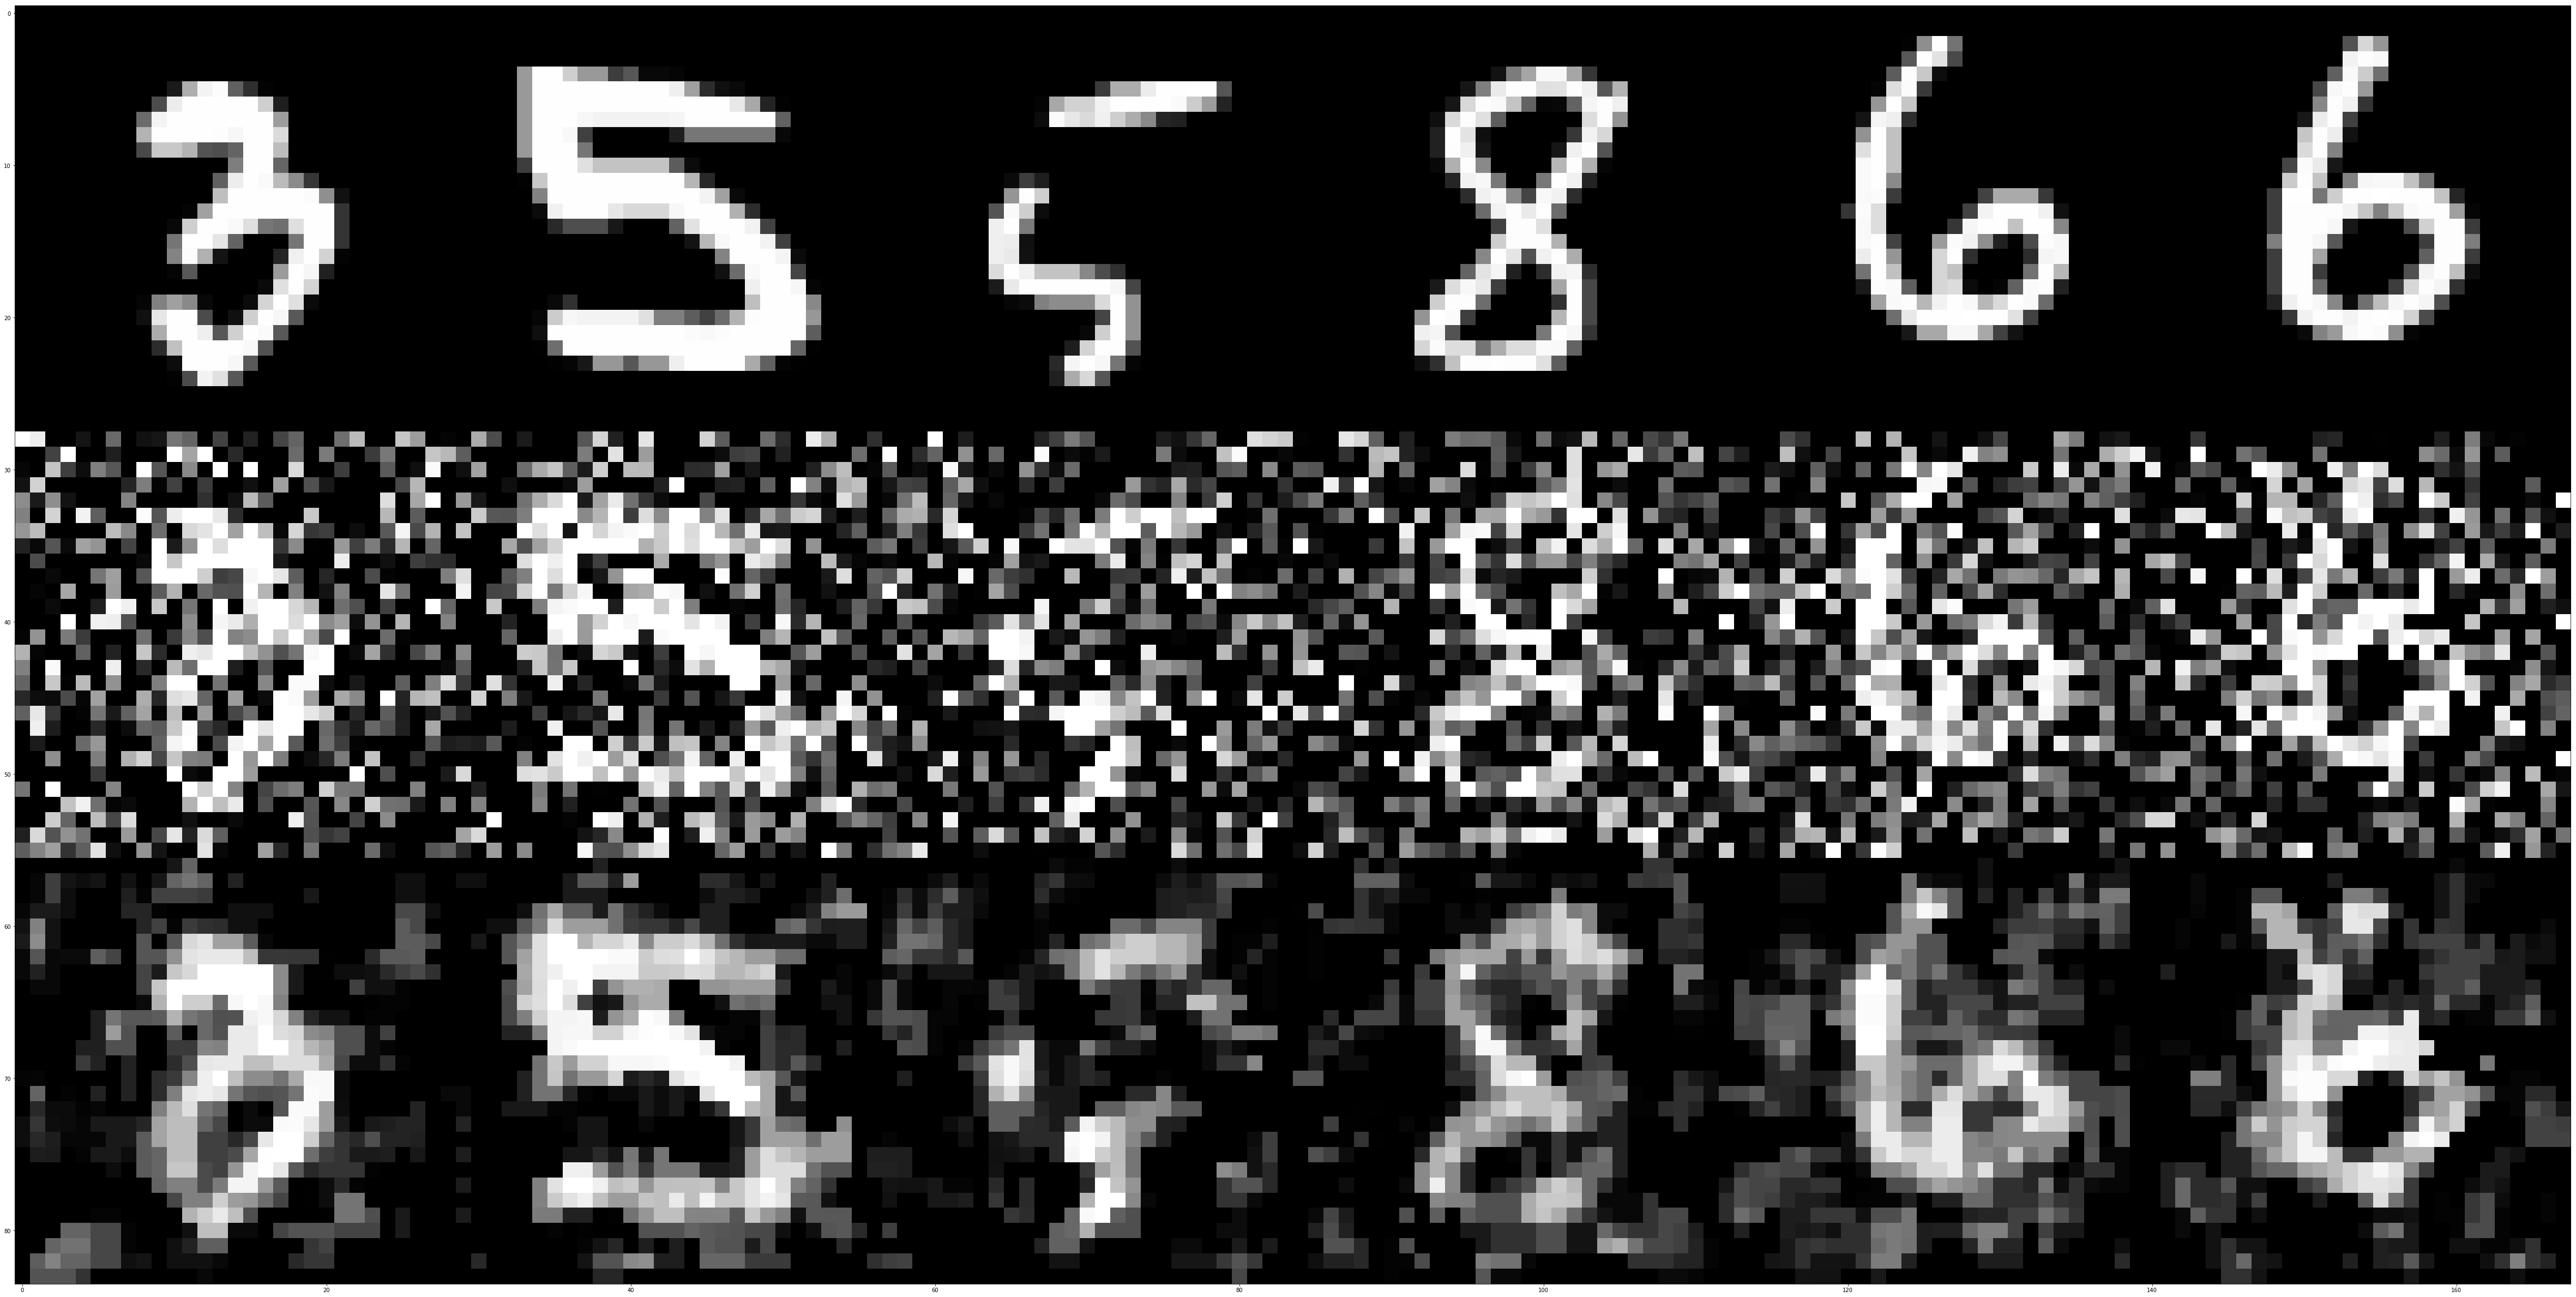

In [4]:
num_train = 50000
n_images = 6
import scipy.signal as signal
figure = np.zeros((28*3 , 28 * n_images))
# Display
showidx=np.random.randint(0,num_train,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_train[idx], [28, 28]),[3,3])
plt.figure(figsize=(28*3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [5]:
#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)
h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [6]:
#decoder part
# we instantiate these layers separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(vae, to_file='model1.png',show_shapes=True)

In [11]:
# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss
vae.compile(optimizer='adam', loss=VAE_loss)

In [13]:
vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 74s 1ms/step - loss: 226.0660 - val_loss: 159.5323
Epoch 2/10
60000/60000 [==============================] - 55s 910us/step - loss: 143.9193 - val_loss: 135.1677
Epoch 3/10
60000/60000 [==============================] - 55s 909us/step - loss: 133.1625 - val_loss: 130.0029
Epoch 4/10
60000/60000 [==============================] - 56s 926us/step - loss: 129.3209 - val_loss: 128.2374
Epoch 5/10
60000/60000 [==============================] - 55s 918us/step - loss: 126.8134 - val_loss: 126.3096
Epoch 6/10
60000/60000 [==============================] - 56s 926us/step - loss: 125.1150 - val_loss: 123.9554
Epoch 7/10
60000/60000 [==============================] - 55s 912us/step - loss: 123.6680 - val_loss: 122.7707
Epoch 8/10
60000/60000 [==============================] - 55s 913us/step - loss: 122.8957 - val_loss: 121.6243
Epoch 9/10
60000/60000 [==============================] - 55s 91

In [18]:
digit_size = 28
figure = np.zeros((digit_size * 4, digit_size * n_images))

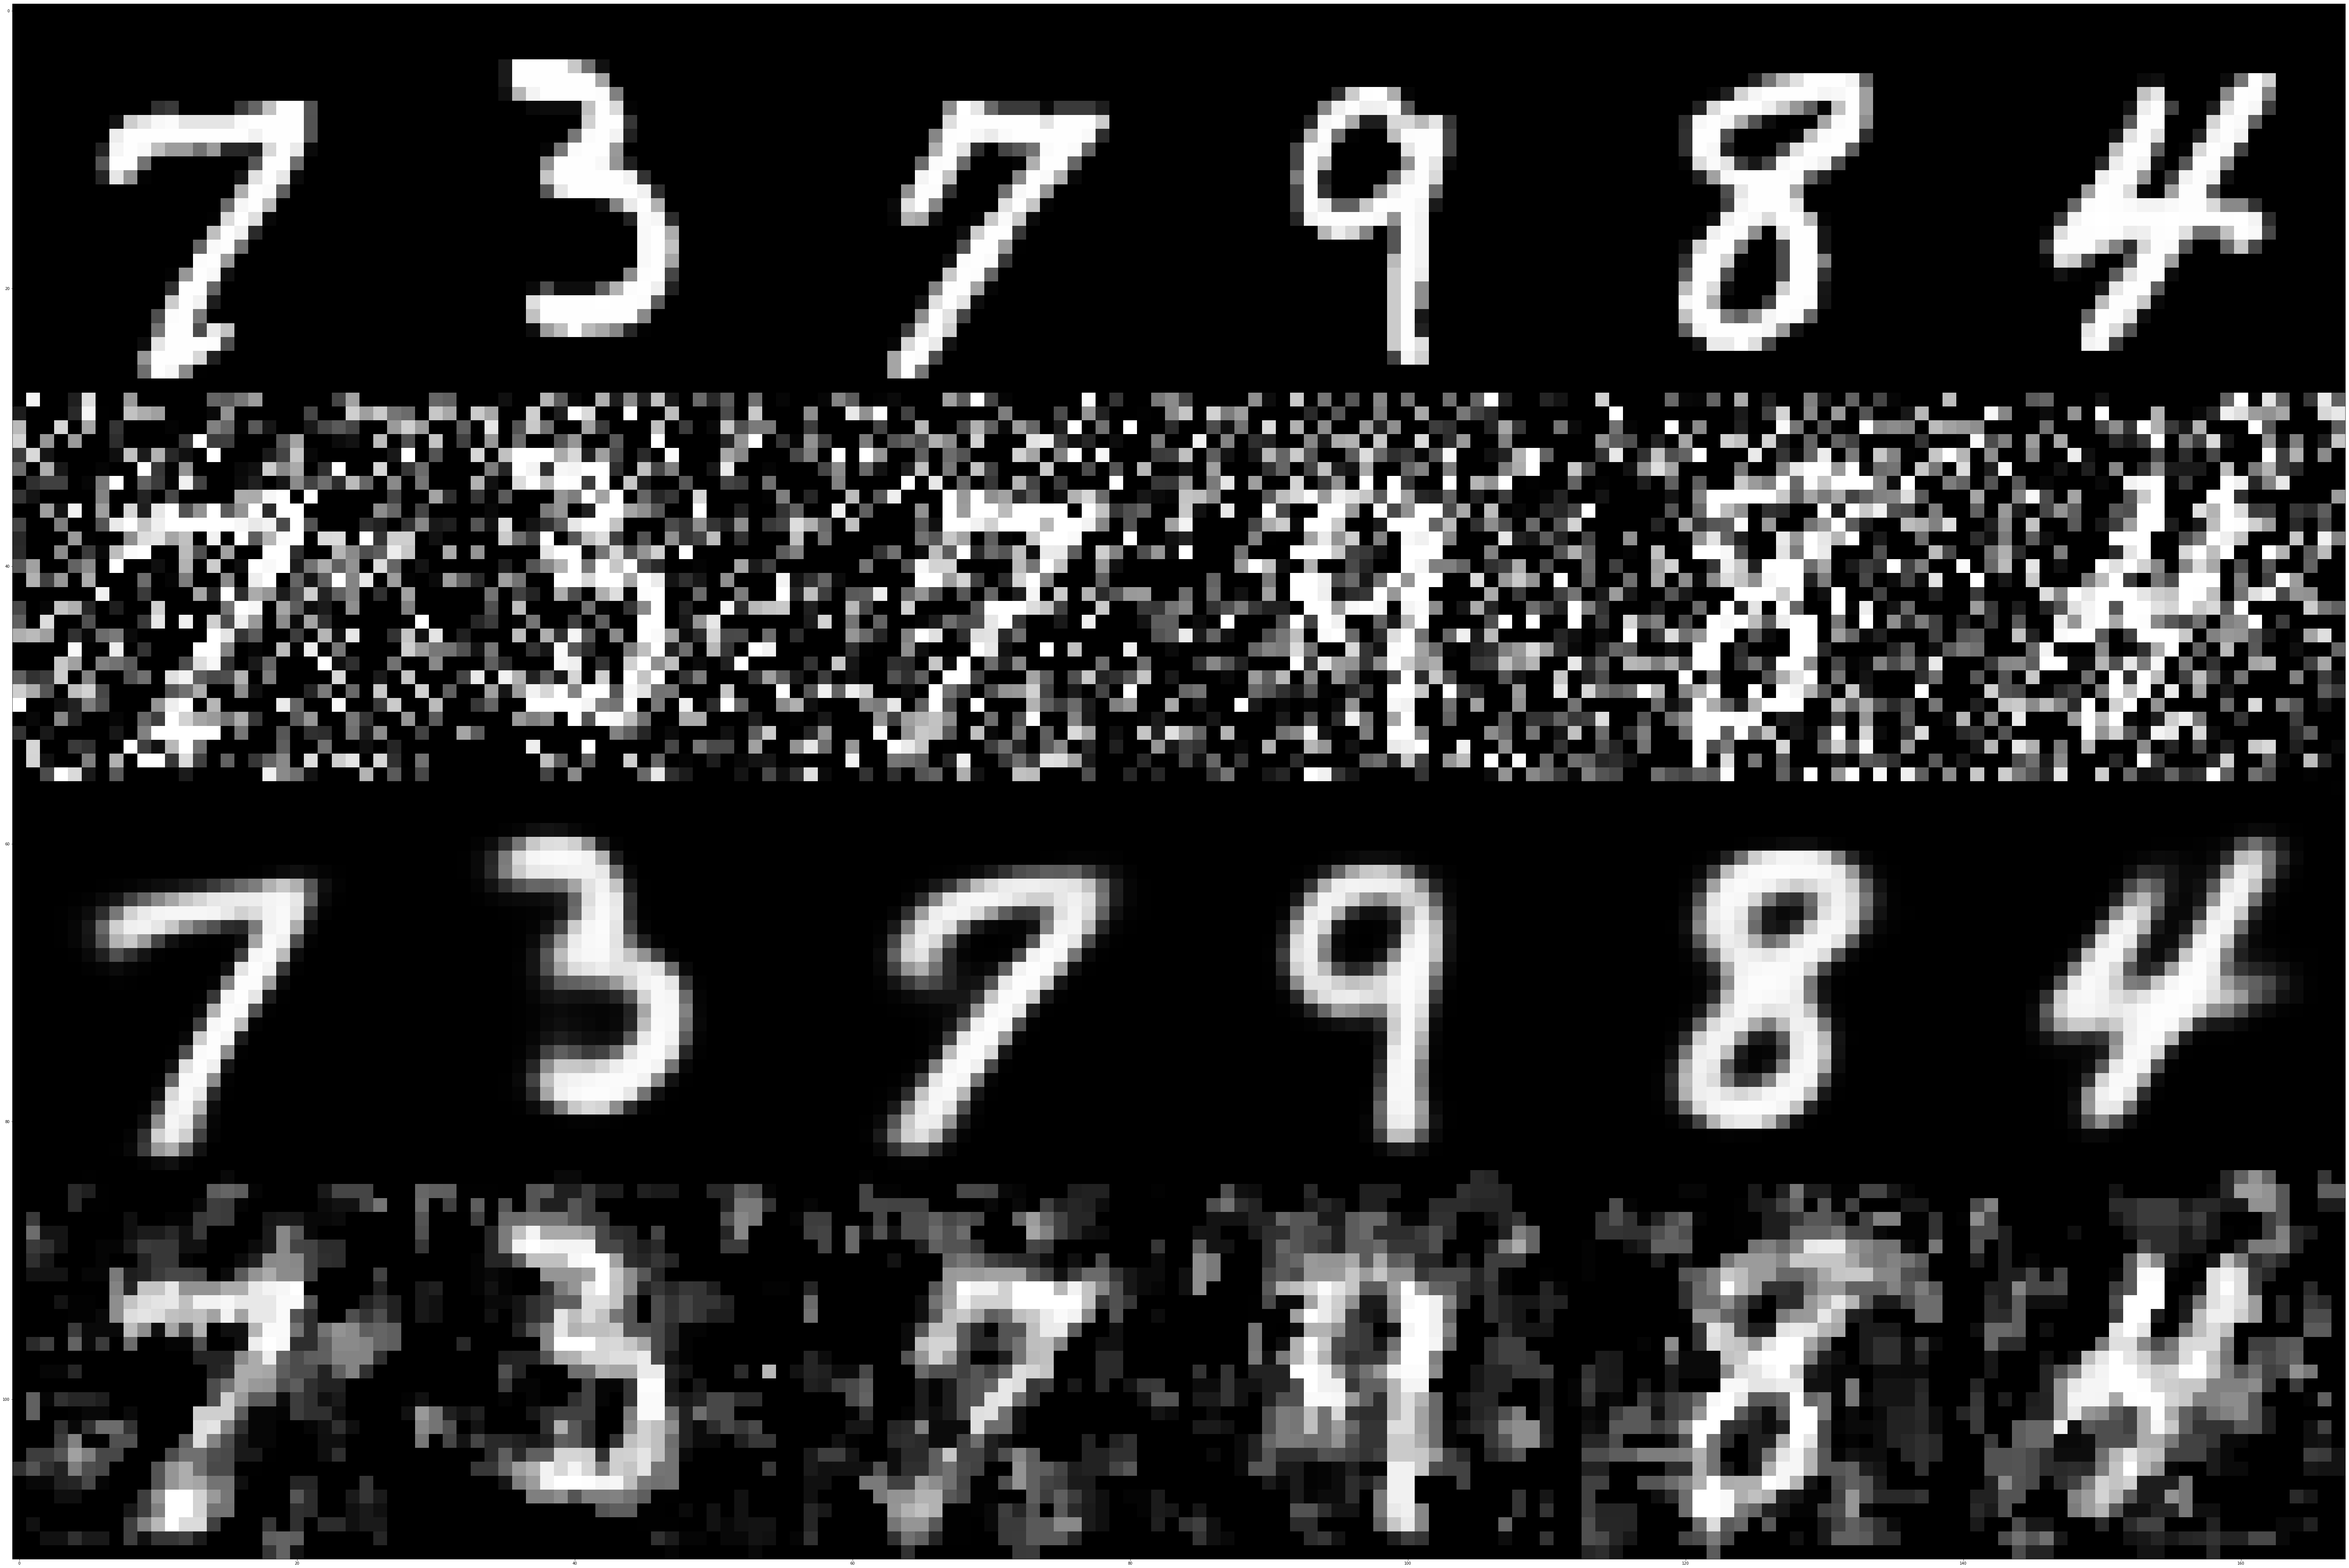

In [22]:
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test[showidx])
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
    figure[28 * 3: 28 * 4,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
plt.figure(figsize=(28 * 4, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('result_keras_VAE.png')
plt.show()